## Private Construction
I felt the Private Construction data needed to be modeled with a non-linear model.  The primary one we learned in class was $H\left(m \right) = T\left( m \right) + C\left( m \right) + \epsilon \left( m \right)$ where $T$ is trend from the base non-linear model(in this case we use moving average), $C$ is the cyclic model for which we use the average value based on a 12 month lag. This model had a better fit than the linear model with a smaller squared error and higher $R^2$.

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
%matplotlib inline
dfPriv = pd.read_csv("ConstructionTimeSeriesDataV2.csv")#download data
dfPriv.head()

,Month,Month-Year,Total Construction,Private Construction,Public Construction
0,1,Jan-02,59516,45273,14243
1,2,Feb-02,58588,44475,14113
2,3,Mar-02,63782,49396,14386
3,4,Apr-02,69504,53283,16221
4,5,May-02,73384,55009,18375


Based on the below plot, I feel private construction is nonlinear.

Text(0,0.5,'Private Construction')

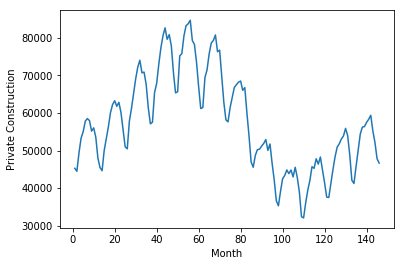

In [5]:
fig,ax=plt.subplots()
ax.plot(dfPriv['Month'],dfPriv['Private Construction'])
plt.xlabel('Month')
plt.ylabel('Private Construction')

### What window
Here we use a moving average to find the overall trend of the model.  I found the lowest squared error using the moving average to occur with a 29 month window. I found this by changing the value of window. After the code, you will see a plot where the blue line is the trend model and the orange line is the actual data.

The average squared error is  27906328.62513241


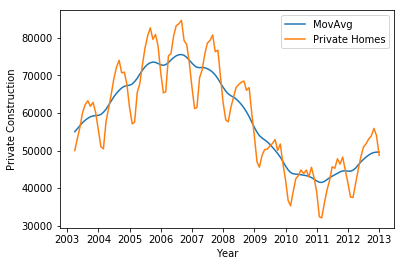

In [6]:
#Finding the TREND ..Use a moving average to help account for the overall quadratic trend we see above.
dfPriv = pd.read_csv("ConstructionTimeSeriesDataV2.csv")#download data
def sqErr(row):
    return(row['Private Construction']-row['MovAvg'])**2
dfPriv['MovAvg']=np.NaN#create a new column
dfPriv['sqErr']=np.NaN#Create a new column
dfPriv.index=pd.DatetimeIndex(freq='m', start=pd.Timestamp(year=2002,month=1,day=1),periods=len(dfPriv['MovAvg']))
window=29 #Lowest squared error at 2790628
window=window-window%2 #want to be sure the window is an even number

for i in range(int(window/2), dfPriv.shape[0]-int(window/2)):
    dfPriv.loc[dfPriv.index[i],'MovAvg'] = (0.5*dfPriv.iloc[i - int(window/2)]['Private Construction'] + dfPriv.iloc[i - int(window/2)+1:i + int(window/2)]['Private Construction'].sum() + 0.5*dfPriv.iloc[i + int(window/2)]['Private Construction'])/float(window)

dfPriv['sqErr']=(dfPriv['Private Construction']-dfPriv['MovAvg'])**2

dfPriv.dropna(how='any',inplace=True)
avgsqErr=sum(dfPriv['sqErr'])/len(dfPriv)
print('The average squared error is ', avgsqErr)

#below we plot the moving average model and the actual data
fig,ax=plt.subplots()
ax.plot(dfPriv['MovAvg'], label='MovAvg')
ax.plot(dfPriv['Private Construction'], label='Private Homes')
plt.xlabel('Year')
plt.ylabel('Private Construction')
plt.legend()

## Accounting for the cycle of the data
Based on the above plot, I feel that the 29 month moving average is a good model to capture the trend. Now we need to decompose our data, seperating the overall trend from the cyclic nature as shown in the below plot (represented by the line R1).

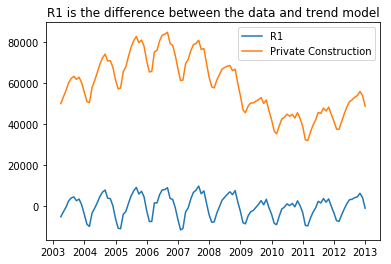

In [7]:
#Determine the seasonality portion
# Subtract out the private cunstruction to determine whats left after the trend.

dfPriv['R1']=dfPriv['Private Construction'] - dfPriv['MovAvg']
dfPriv['R1Error']=abs((dfPriv['Private Construction'] - dfPriv['R1'])/dfPriv['Private Construction'])
plt.plot(dfPriv['R1'])
plt.plot(dfPriv['Private Construction'])
plt.title('R1 is the difference between the data and trend model')
plt.legend()
#looks like we have a good match for the seasonality. At LEast the seasonality components look similiar.

## Determining the highest autocorrelation with lag. 
Below we look at the correlation of each time period with the other time periods.  The is the autocorrelation and just like correlation the larger vale the better.

In [8]:
#Here we determine the best possible lag to model the cyclic behavior.
maxCorr=0.0
period=np.NaN
for i in range(1,50):
    corr=dfPriv['R1'].autocorr(lag=i)#finding correlation for 50 previous time periods.
    #print('Correlation, lag ',i,'   ',corr)
    if corr>maxCorr:
        maxCorr=corr
        period=i
print('period= ',period,'   Max Correlation= ',maxCorr)

period=  12    Max Correlation=  0.8927182172333031


## Determine the Cycle with Lag
I figured the best lag would be 12 based on the seasonality and my previous analysis.With a autocorrelation of 0.89 this is supported.  Now we determine the average value for each month (12 months in a year and this is how our data is formatted). to account for the cyclic trend.  For example, we can add the average change for January to our model to account for the cycle in month 1.

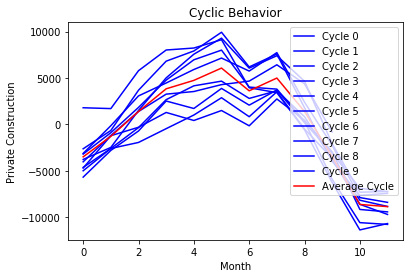

In [9]:
#I completly copied this code from the lecture.  However, I know it is a pithy way to find the average for each month in our 
#cycle and then annotate this to our dataframe.
period=12
cycleLen=period
numCycles=int(len(dfPriv)/cycleLen+0.5)
cycles = [dfPriv.iloc[range(i*period,min((i+1)*period,len(dfPriv)))]['R1'] for i in range(numCycles)]
ptsInCycles = [dfPriv.iloc[range(i,len(dfPriv['R1']),period)]['R1'].tolist() for i in range(period)]
avg = [sum(pts)/len(pts) for pts in ptsInCycles]

fig,ax = plt.subplots()
for i in range(len(cycles)):
    ax.plot(cycles[i].values,label='Cycle '+str(i),c='b')
ax.plot(avg,label='Average Cycle',c='r')
ax.set_xlabel('Month')
ax.set_ylabel('Private Construction')
plt.title('Cyclic Behavior')
ax.legend()


Based on the above plot it looks like we have a good match using the mean with this 12 month period. Now we can annotate our cyclic model into our data frame.  This is a column called C.  We can visually judge our model &ndash; the cyclic model (C) fits closely with the data with the trend removed (R1).  As the below plot shows, we have a good match with our cyclic model.

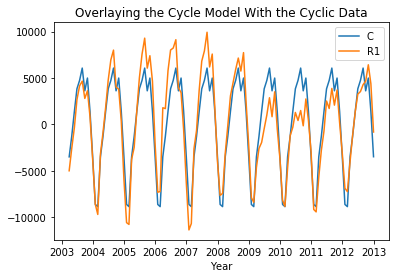

In [10]:
cycleLen=period
numCycles=int(len(dfPriv)/cycleLen+0.5)
dfPriv['C']=np.NaN
for i in range(len(dfPriv)):
    dfPriv.loc[dfPriv.index[i], 'C']=avg[i % cycleLen] # this is a cool trick to avoid a second for loop (I think)
dfPriv[['C']]

plt.plot(dfPriv['C'])
plt.plot(dfPriv['R1'])
plt.xlabel('Year')
plt.title('Overlaying the Cycle Model With the Cyclic Data')
plt.legend()
# We have a good fit for the seasonality - now we can bring it together.

 ## Assessing the Model

Now we have our trend, $T$, and our cycle, $C$, all we need to do is bring the model together.  We define $R2$ which is the difference in the model when the trend is removed and $R2$Error which is the absolute value $R2$ divided by the actual data. We see the average error is small at 3%. Notice the below plot shows a very close fit between our model and the data.   

Average Error:  0.029087345816844315
                     R1   R1Error            C           R2   R2Error  \
2003-04-30 -2599.535714  1.048868 -1295.521429 -1304.014286  0.024514   
2003-05-31  -353.857143  1.006287  1388.075000 -1741.932143  0.030948   
2003-06-30  2659.500000  0.955731  3828.973214 -1169.473214  0.019467   
2003-07-31  4150.017857  0.933297  4736.237500  -586.219643  0.009422   
2003-08-31  4655.375000  0.926379  6063.992857 -1408.617857  0.022276   
2003-09-30  2792.910714  0.954783  3611.912500  -819.001786  0.013260   
2003-10-31  3614.339286  0.942459  4988.610714 -1374.271429  0.021879   
2003-11-30   819.517857  0.986367  1385.458929  -565.941071  0.009414   
2003-12-31 -3773.000000  1.067879 -3493.264286  -279.735714  0.005033   

                     fit  
2003-04-30  54499.014286  
2003-05-31  58027.932143  
2003-06-30  61245.473214  
2003-07-31  62802.219643  
2003-08-31  64642.617857  
2003-09-30  62586.001786  
2003-10-31  64187.271429  
2003-11-30  6068

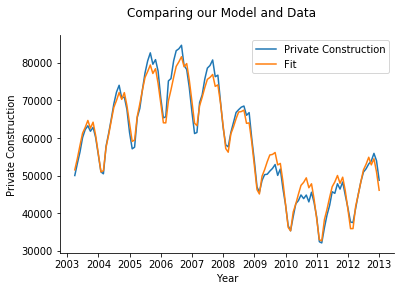

In [230]:
dfPriv['R2'] = dfPriv['R1'] - dfPriv['C']
dfPriv['R2Error'] = abs(dfPriv['R2']/dfPriv['Private Construction'])
dfPriv['fit'] = dfPriv['MovAvg'] + dfPriv['C']
print('Average Error: ', sum(dfPriv['R2Error'])/len(dfPriv))
print(dfPriv.iloc[1:10,7:13])
fig,ax = plt.subplots()
ax.plot(dfPriv['Private Construction'],label='Private Construction')
ax.plot(dfPriv['fit'], label = 'Fit')
ax.set_xlabel('Year')
ax.set_ylabel('Private Construction')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.suptitle('Comparing our Model and Data')
leg=ax.legend()

## Cumulative squared error
The cumulative squared error can be seen below. At nearly 500 million this seems like a huge number.  However, we had to square the error to prevent counter balancing between the positive and negatives.  Now we can take the square root of this value and get an error of just over 22,000.  This is a fraction of the monthly value of our dependent variable.  Finally, I found the $R^2$ for the fun of it to be 0.97, which is probably a bit too good.

In [206]:
dfPriv['R2Private']=dfPriv['Private Construction']-dfPriv['fit'] #As stated in assignment - delta between real data and model
dfPriv['R2ErrorPrivate']=dfPriv['R2Private']/dfPriv['Private Construction'] #error  relative to (divided by) the original data series.
dfPriv['squaredError']=dfPriv['R2Private']**2 #squared error
dfPriv['cumulativeSquaredError'] = dfPriv['squaredError'].cumsum()#cumulative squared error
print('The Cumulative Square error is ', dfPriv.iloc[-1,16] )
print('the Cum. Square error seems big, but the square root is ',(dfPriv.iloc[-1,16])**.5)
dfPriv.iloc[1:10,[0,8,9,10,11,13,14,15, 16]]

The Cumulative Square error is  495360484.72120166
the Cum. Square error seems big, but the square root is  22256.695278526902


,Month,R1Error,C,R2,R2Error,R2Private,R2ErrorPrivate,squaredError,cumulativeSquaredError
2003-04-30,16,1.048868,-1295.521429,-1304.014286,0.024514,-1304.014286,-0.024514,1.700453e+06,3.952136e+06
2003-05-31,17,1.006287,1388.075000,-1741.932143,0.030948,-1741.932143,-0.030948,3.034328e+06,6.986463e+06
2003-06-30,18,0.955731,3828.973214,-1169.473214,0.019467,-1169.473214,-0.019467,1.367668e+06,8.354131e+06
2003-07-31,19,0.933297,4736.237500,-586.219643,0.009422,-586.219643,-0.009422,3.436535e+05,8.697784e+06
2003-08-31,20,0.926379,6063.992857,-1408.617857,0.022276,-1408.617857,-0.022276,1.984204e+06,1.068199e+07
2003-09-30,21,0.954783,3611.912500,-819.001786,0.013260,-819.001786,-0.013260,6.707639e+05,1.135275e+07
2003-10-31,22,0.942459,4988.610714,-1374.271429,0.021879,-1374.271429,-0.021879,1.888622e+06,1.324137e+07
2003-11-30,23,0.986367,1385.458929,-565.941071,0.009414,-565.941071,-0.009414,3.202893e+05,1.356166e+07
2003-12-31,24,1.067879,-3493.264286,-279.735714,0.005033,-279.735714,-0.005033,7.825207e+04,1.363992e+07


In [168]:
ssrCol=[]
ssrCol=(dfPriv['fit']-dfPriv['Private Construction'].mean())*(dfPriv['fit']-dfcon['Private Construction'].mean())
ssr = ssrCol.sum()
sse=dfPriv['squaredError'].sum()
sst=sse+ssr
rsquared=ssr/sst
print(rsquared)

0.9742581236751826
